In [10]:
import os, glob, re, gc, random
import pandas as pd
import numpy as np
import torch
import torchaudio
import torchaudio.transforms as T
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# =============================================================================
# 1. DIRECT PATHS
# =============================================================================
base_path       = '/kaggle/input/datasets/surya5510/newdataset'
fsd50k_dev_csv  = f"{base_path}/dev.csv"
fsd50k_eval_csv = f"{base_path}/eval.csv"
fsd50k_dev_dir  = f"{base_path}/FSD50K.dev_audio/FSD50K.dev_audio/FSD50K.dev_audio"
fsd50k_eval_dir = f"{base_path}/FSD50K.eval_audio/FSD50K.eval_audio"
librispeech_dir = f"{base_path}/LibriSpeech/LibriSpeech/train-clean-100"

# =============================================================================
# 2. NORMALIZATION FUNCTION
# =============================================================================
def normalize_label(label):
    label = str(label).lower()
    label = label.replace('_and_', ' ').replace('_or_',  ' ')
    label = label.replace('_', ' ').replace('-', ' ').replace('(', ' ').replace(')', ' ')
    label = label.replace(',', ' ').replace('/', ' ').replace('.', ' ').replace("'", ' ')
    stopwords = {'and', 'or', 'the'}
    words     = [w for w in label.split() if w not in stopwords]
    return ' '.join(words).strip()

# =============================================================================
# 3. UPDATED 6-STEM CATEGORIZATION LOGIC
# Resolves the ❌ None Errors by expanding the mapping for macro-stems.
# =============================================================================
LABEL_CONFLICT_RESOLUTION = {
    'Speech':        1,  # Vocal Core
    'Music':         2,  # Melodic/Harmonic
    'Impacts':       3,  # Transients (Sharp vertical shapes)
    'Alerts':        4,  # Sine-waves (Sustained horizontal shapes)
    'Environmental': 5,  # Stochastic chaos (Nature + Animals + Crowd)
    'Mechanical':    6,  # Periodic Drones (Mechanical + Domestic + Urban)
}

STEMS = list(LABEL_CONFLICT_RESOLUTION.keys())

LABEL_TO_SUPERCLASS_RAW = {
    # ── Speech ──
    'Speech': 'Speech', 'Male speech man speaking': 'Speech', 
    'Female speech woman speaking': 'Speech', 'Child speech kid speaking': 'Speech',
    'Conversation': 'Speech', 'Whispering': 'Speech', 'Shout': 'Speech',

    # ── Music ──
    'Music': 'Music', 'Musical instrument': 'Music', 'Guitar': 'Music', 
    'Piano': 'Music', 'Drum': 'Music', 'Synthesizer': 'Music', 'Singing': 'Music',

    # ── Impacts (Transient Events) ──
    'Gunshot gunfire': 'Impacts', 'Explosion': 'Impacts', 'Bang': 'Impacts',
    'Slam': 'Impacts', 'Knock': 'Impacts', 'Breaking': 'Impacts', 
    'Chink clink': 'Impacts',  # Resolved missing mapping

    # ── Alerts (Signaling Tones) ──
    'Alarm': 'Alerts', 'Siren': 'Alerts', 'Bell': 'Alerts', 'Chime': 'Alerts',
    'Beep bleep': 'Alerts', 'Ringtone': 'Alerts', 'Telephone bell ringing': 'Alerts',

    # ── Environmental (Consolidated Nature/Animal/Crowd) ──
    'Bird': 'Environmental', 'Animal': 'Environmental', 'Dog': 'Environmental',
    'Rain': 'Environmental', 'Wind': 'Environmental', 'Thunderstorm': 'Environmental',
    'Crowd': 'Environmental', 'Applause': 'Environmental', 'Chatter': 'Environmental',
    'Ocean': 'Environmental', 'Water': 'Environmental', 'Insect': 'Environmental',

    # ── Mechanical (Consolidated Urban/Domestic/Drones) ──
    'Engine': 'Mechanical', 'Vacuum cleaner': 'Mechanical', 'Chainsaw': 'Mechanical',
    'Traffic noise roadway noise': 'Mechanical', 'Car': 'Mechanical', 
    'Train': 'Mechanical', 'Washing machine': 'Mechanical', 'Air conditioning': 'Mechanical',
    'Bathtub filling washing': 'Mechanical', # Resolved missing mapping
    'Sink filling washing': 'Mechanical',
    'Water tap faucet': 'Mechanical'
}

NORMALIZED_MAP = {normalize_label(k): v for k, v in LABEL_TO_SUPERCLASS_RAW.items()}
print(f"✅ NORMALIZED_MAP built: {len(NORMALIZED_MAP)} entries")

# =============================================================================
# 4. DUPLICATE VERIFICATION
# =============================================================================
def verify_no_duplicates(raw_dict):
    normalized_keys = [normalize_label(k) for k in raw_dict.keys()]
    seen = {}
    duplicates_found = False
    for original, normalized in zip(raw_dict.keys(), normalized_keys):
        if normalized in seen:
            print(f"❌ DUPLICATE: '{original}' collides with : '{seen[normalized]}'")
            duplicates_found = True
        else:
            seen[normalized] = original
    if not duplicates_found:
        print("✅ No duplicates found in LABEL_TO_SUPERCLASS_RAW")
    return not duplicates_found

# =============================================================================
# 5. ASSIGN SUPERCLASS & LOAD
# =============================================================================
def assign_superclass(labels_str):
    full_normalized = normalize_label(labels_str)
    words           = full_normalized.split()
    superclasses    = []
    i = 0
    while i < len(words):
        matched = False
        for length in range(min(6, len(words) - i), 0, -1):
            phrase     = ' '.join(words[i:i+length])
            superclass = NORMALIZED_MAP.get(phrase)
            if superclass:
                superclasses.append(superclass)
                i      += length
                matched = True
                break
        if not matched: i += 1
    if not superclasses: return None
    return min(superclasses, key=lambda x: LABEL_CONFLICT_RESOLUTION[x])

def verify_normalization():
    test_cases = [
        ('Bird_vocalization_and_bird_call_and_bird_song', 'Environmental'),
        ('Bathtub_(filling_or_washing)',                  'Mechanical'),
        ('Traffic_noise,_roadway_noise',                  'Mechanical'),
        ('Chink_and_clink',                               'Impacts'),
        ('Child_speech_and_kid_speaking',                 'Speech'),
        ('Smoke_detector,_smoke_alarm',                   'Alerts'),
        ('Electric_guitar',                               'Music'),
        ('Rain',                                          'Environmental'),
        ('Gunshot_gunfire',                               'Impacts'),
    ]
    print("\n" + "="*72 + "\n   6-STEM NORMALIZATION VERIFICATION\n" + "="*72)
    all_pass = True
    for raw, expected in test_cases:
        got = assign_superclass(raw)
        ok = '✅' if got == expected else '❌'
        if got != expected: all_pass = False
        print(f"  {raw:<50} {expected:<15} {str(got):<15} {ok}")
    return all_pass

def load_and_merge_fsd50k_6stem(dev_csv, eval_csv, dev_dir, eval_dir):
    all_noise = {stem: [] for stem in STEMS if stem != 'Speech'}
    discarded = 0
    df_all = pd.concat([pd.read_csv(dev_csv)[['fname', 'labels']], 
                        pd.read_csv(eval_csv)[['fname', 'labels']]], ignore_index=True)

    for _, row in df_all.iterrows():
        superclass = assign_superclass(row['labels'])
        if not superclass or superclass == 'Speech':
            discarded += 1
            continue
        path = os.path.join(dev_dir, str(row['fname']) + '.wav')
        if not os.path.exists(path):
            path = os.path.join(eval_dir, str(row['fname']) + '.wav')
        if not os.path.exists(path):
            discarded += 1
            continue
        all_noise[superclass].append(path)
    print(f"Total FSD50K clips after merge : {len(df_all)}")
    print(f"Discarded (unknown label or missing file) : {discarded}")
    return all_noise

# RUN EXECUTION
verify_no_duplicates(LABEL_TO_SUPERCLASS_RAW)
verify_normalization()
noise_data_raw = load_and_merge_fsd50k_6stem(fsd50k_dev_csv, fsd50k_eval_csv, fsd50k_dev_dir, fsd50k_eval_dir)
speech_files_raw = glob.glob(os.path.join(librispeech_dir, "**/*.flac"), recursive=True)

print(f"\nInventory Verified (6-Stem Pivot):")
print(f"✅ Speech (Vocal Stem)  : {len(speech_files_raw)} files")
for stem in STEMS:
    if stem != 'Speech':
        print(f"✅ {stem:<12} Stem   : {len(noise_data_raw[stem])} files")

✅ NORMALIZED_MAP built: 51 entries
✅ No duplicates found in LABEL_TO_SUPERCLASS_RAW

   6-STEM NORMALIZATION VERIFICATION
  Bird_vocalization_and_bird_call_and_bird_song      Environmental   Environmental   ✅
  Bathtub_(filling_or_washing)                       Mechanical      Mechanical      ✅
  Traffic_noise,_roadway_noise                       Mechanical      Mechanical      ✅
  Chink_and_clink                                    Impacts         Impacts         ✅
  Child_speech_and_kid_speaking                      Speech          Speech          ✅
  Smoke_detector,_smoke_alarm                        Alerts          Alerts          ✅
  Electric_guitar                                    Music           Music           ✅
  Rain                                               Environmental   Environmental   ✅
  Gunshot_gunfire                                    Impacts         Impacts         ✅
Total FSD50K clips after merge : 51197
Discarded (unknown label or missing file) : 36695

Inven

6-Stem Noise categories found: ['Music', 'Impacts', 'Alerts', 'Environmental', 'Mechanical']
🚀 Performing 6-Stem Signal Integrity Audit...


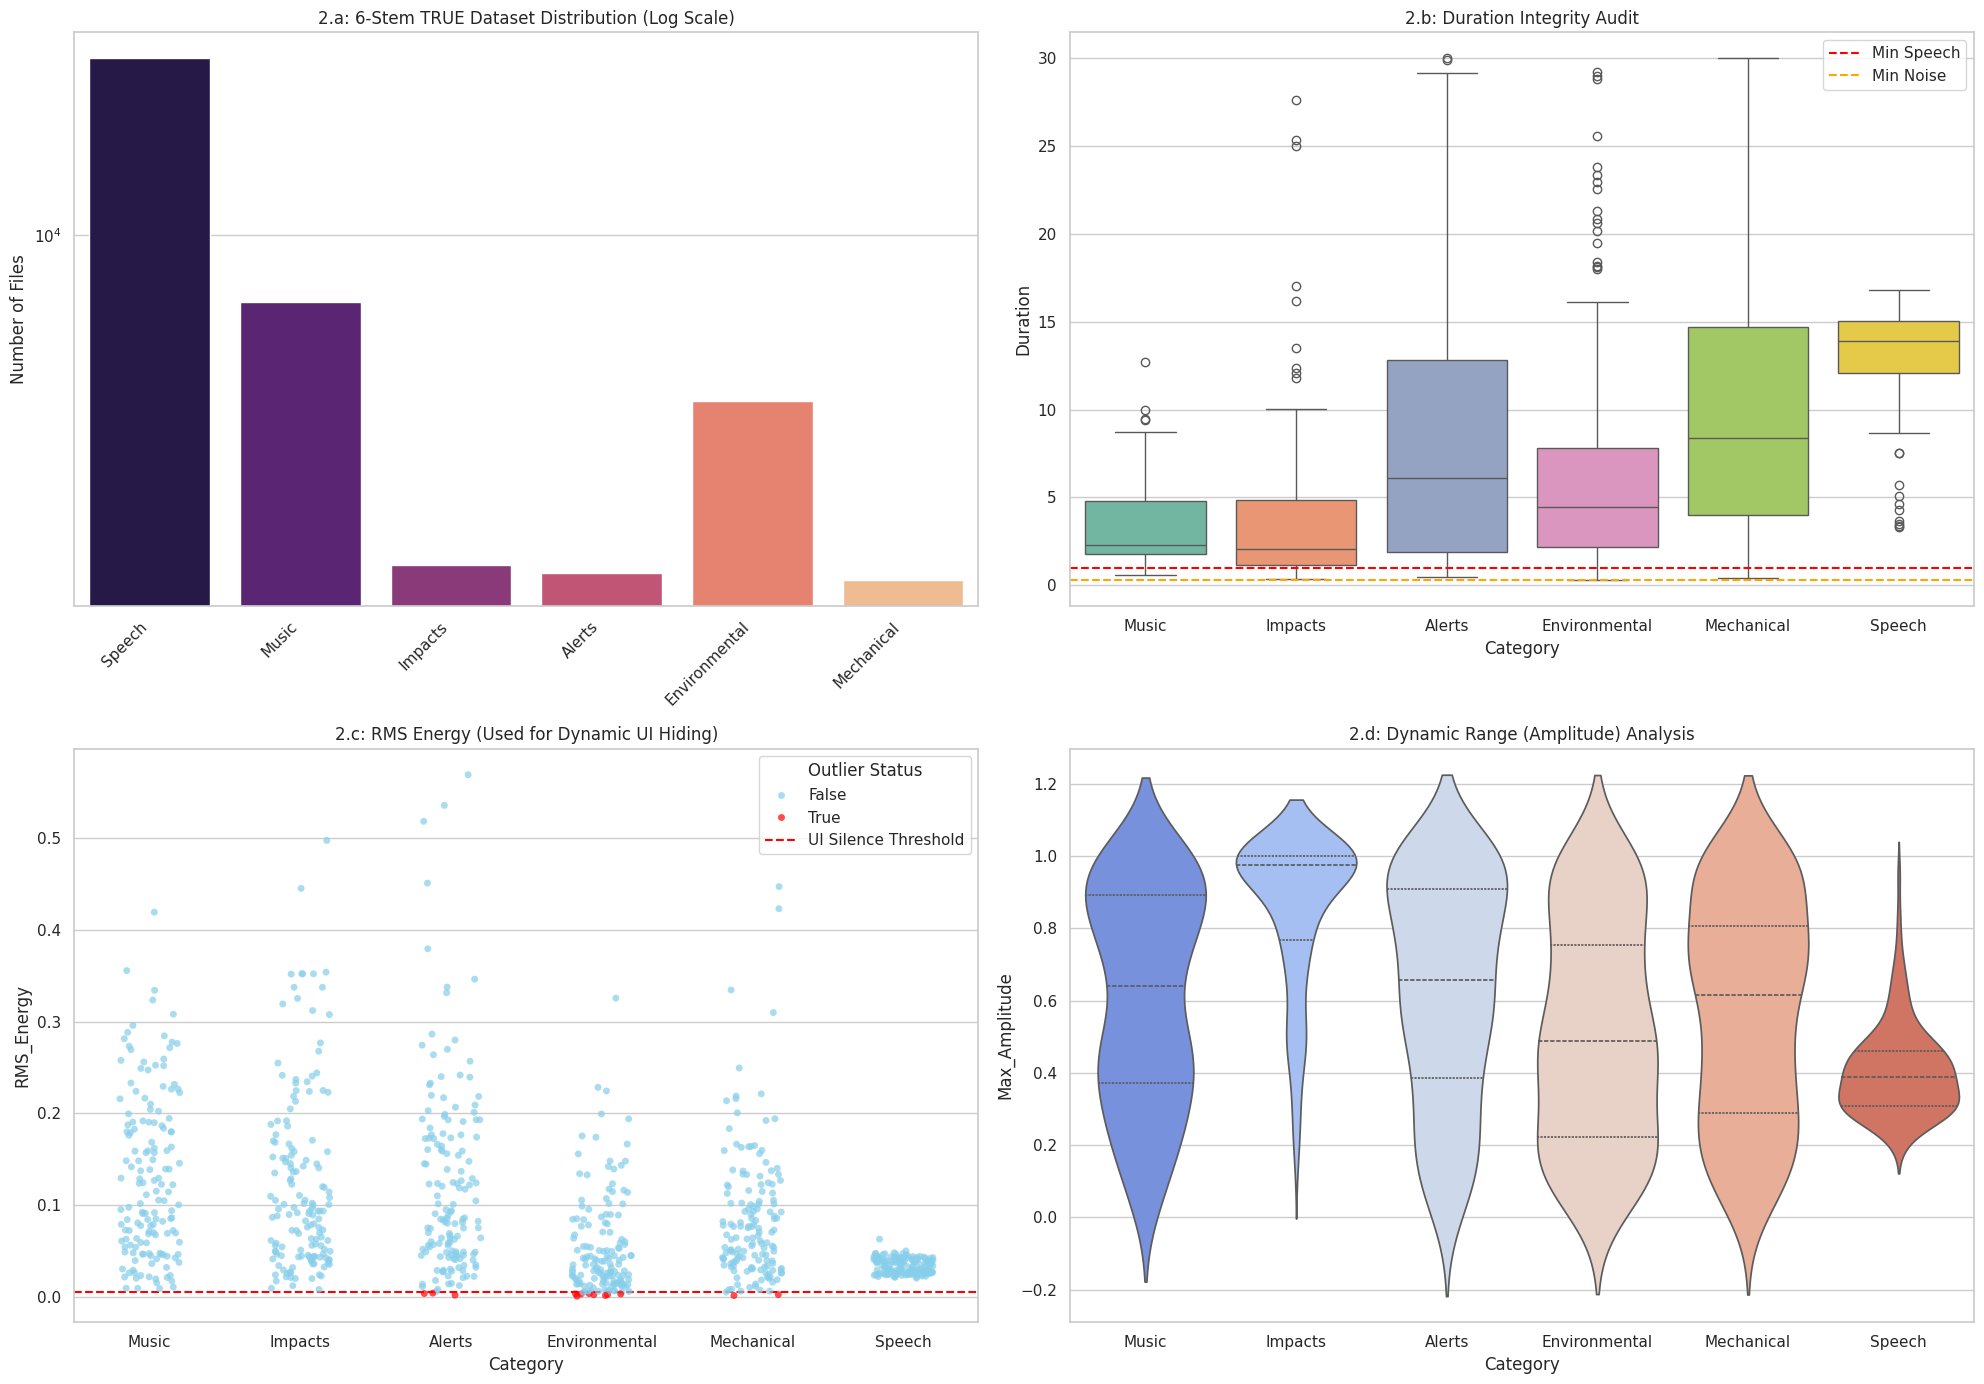


6-STEM EDA SUMMARY FOR PROJECT DOCUMENTATION
Total Silence Outliers Detected (Sample): 13
Total Short Outliers Detected (Sample)  : 0

Average Duration per Macro-Category (Seconds):
Category
Alerts            8.51
Environmental     6.82
Impacts           3.81
Mechanical       10.61
Music             3.53
Speech           13.18
Name: Duration, dtype: float64

6-STEM OUTLIER SOURCE REPORT
                Silent_Files  Short_Files
Source_Dataset                           
FSD50K                    13            0
LibriSpeech                0            0

FSD50K Sample Integrity Rate: 98.27%

LibriSpeech Sample Integrity Rate: 100.00%


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchaudio
import os

# Ensure previous inventory is available
print(f"6-Stem Noise categories found: {list(noise_data_raw.keys())}")

# Constants for purging logic
SPEECH_DUR_THRESHOLD = 1.0
NOISE_DUR_THRESHOLD  = 0.3
RMS_THRESHOLD        = 0.005

def run_comprehensive_6stem_eda(speech_list, noise_dict, rms_threshold=0.005):
    stats = []
    print("🚀 Performing 6-Stem Signal Integrity Audit...")

    # Consolidated 6-stem audit pool
    audit_pool = {**noise_dict, 'Speech': speech_list}
    
    for cat, files in audit_pool.items():
        cat_dur_threshold = SPEECH_DUR_THRESHOLD if cat == 'Speech' else NOISE_DUR_THRESHOLD
        
        # Sample 150 files per category for statistical significance
        for f in files[:150]:
            if not os.path.exists(f): 
                continue
            try:
                # Robust load (direct tensor calculation)
                wav, sr = torchaudio.load(f)
                
                duration = wav.shape[1] / sr
                rms_energy = torch.sqrt(torch.mean(wav**2)).item()
                max_amp = torch.max(torch.abs(wav)).item()

                stats.append({
                    'Category': cat,
                    'Duration': duration,
                    'RMS_Energy': rms_energy,
                    'Max_Amplitude': max_amp,
                    'is_silent': rms_energy < rms_threshold,
                    'is_too_short': duration < cat_dur_threshold
                })
            except Exception:
                continue

    df_eda = pd.DataFrame(stats)
    
    if df_eda.empty:
        print("❌ ERROR: No audio files were successfully audited. Check paths.")
        return None

    # --- VISUALIZATION SECTION ---
    plt.figure(figsize=(20, 14))
    sns.set_theme(style="whitegrid")

    # Plot 1: TRUE Dataset Distribution (Full Inventory counts)
    plt.subplot(2, 2, 1)
    true_counts = {
        'Speech': len(speech_list),
        **{k: len(v) for k, v in noise_dict.items()}
    }
    sns.barplot(x=list(true_counts.keys()), y=list(true_counts.values()), 
                hue=list(true_counts.keys()), palette='magma', legend=False)
    plt.yscale('log')
    plt.xticks(rotation=45, ha='right')
    plt.title("2.a: 6-Stem TRUE Dataset Distribution (Log Scale)")
    plt.ylabel("Number of Files")

    # Plot 2: Duration Audit (Visualizing purging boundaries)
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df_eda, x='Category', y='Duration', hue='Category', palette='Set2', legend=False)
    plt.axhline(y=SPEECH_DUR_THRESHOLD, color='red', linestyle='--', label='Min Speech')
    plt.axhline(y=NOISE_DUR_THRESHOLD, color='orange', linestyle='--', label='Min Noise')
    plt.title("2.b: Duration Integrity Audit")
    plt.legend()

    # Plot 3: Signal Integrity (RMS Energy - Slider Hiding Proof)
    plt.subplot(2, 2, 3)
    sns.stripplot(data=df_eda, x='Category', y='RMS_Energy', 
                  hue='is_silent', palette={True: 'red', False: 'skyblue'},
                  jitter=0.2, alpha=0.7)
    plt.axhline(y=rms_threshold, color='red', linestyle='--', label='UI Silence Threshold')
    plt.title("2.c: RMS Energy (Used for Dynamic UI Hiding)")
    plt.legend(title="Outlier Status")

    # Plot 4: Dynamic Range per Macro-Stem
    plt.subplot(2, 2, 4)
    sns.violinplot(data=df_eda, x='Category', y='Max_Amplitude', hue='Category',
                   inner="quart", palette='coolwarm', legend=False)
    plt.title("2.d: Dynamic Range (Amplitude) Analysis")

    plt.tight_layout()
    plt.show()

    # --- SUMMARY REPORT ---
    print("\n" + "="*50)
    print("6-STEM EDA SUMMARY FOR PROJECT DOCUMENTATION")
    print("="*50)
    print(f"Total Silence Outliers Detected (Sample): {df_eda['is_silent'].sum()}")
    print(f"Total Short Outliers Detected (Sample)  : {df_eda['is_too_short'].sum()}")
    print("\nAverage Duration per Macro-Category (Seconds):")
    print(df_eda.groupby('Category')['Duration'].mean().round(2))

    return df_eda

# Execute the 6-stem Audit
eda_results = run_comprehensive_6stem_eda(speech_files_raw, noise_data_raw)

def report_6stem_outlier_sources(df_eda):
    if df_eda is None: return
    
    print("\n" + "="*50)
    print("6-STEM OUTLIER SOURCE REPORT")
    print("="*50)

    df_eda['Source_Dataset'] = df_eda['Category'].apply(
        lambda x: 'LibriSpeech' if x == 'Speech' else 'FSD50K'
    )

    source_report = df_eda.groupby('Source_Dataset').agg({
        'is_silent': 'sum',
        'is_too_short': 'sum'
    }).rename(columns={'is_silent': 'Silent_Files', 'is_too_short': 'Short_Files'})

    print(source_report)

    for source in source_report.index:
        total = len(df_eda[df_eda['Source_Dataset'] == source])
        outliers = source_report.loc[source].sum()
        integrity = ((total - outliers) / total) * 100
        print(f"\n{source} Sample Integrity Rate: {integrity:.2f}%")

# Run Source Report
report_6stem_outlier_sources(eda_results)

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchaudio
import os

# =============================================================================
# 6-STEM COMPREHENSIVE AUDIT & STATS (Unified)
# =============================================================================
def run_unified_6stem_analysis(speech_list, noise_dict, rms_threshold=0.005):
    stats = []
    print("🚀 Initializing 6-Stem Signal Integrity Audit...")

    # Pool speech + 5 noise macro-stems
    audit_pool = {**noise_dict, 'Speech': speech_list}
    
    for cat, files in audit_pool.items():
        cat_dur_threshold = SPEECH_DUR_THRESHOLD if cat == 'Speech' else NOISE_DUR_THRESHOLD
        
        # Audit a robust sample of 150 files per category
        for f in files[:150]:
            if not os.path.exists(f): continue
            try:
                # Direct load to bypass 'info' attribute errors
                wav, sr = torchaudio.load(f)
                duration = wav.shape[1] / sr
                rms_energy = torch.sqrt(torch.mean(wav**2)).item()
                max_amp = torch.max(torch.abs(wav)).item()

                stats.append({
                    'Category': cat,
                    'Duration': duration,
                    'RMS_Energy': rms_energy,
                    'Max_Amplitude': max_amp,
                    'is_silent': rms_energy < rms_threshold,
                    'is_too_short': duration < cat_dur_threshold
                })
            except: continue

    # Create DataFrame in the local scope
    df_results = pd.DataFrame(stats)

    if df_results.empty:
        print("❌ CRITICAL ERROR: No data was collected. Check Section 1 Paths!")
        return None



    # --- 2. STATISTICAL TABLE ---
    print("\n" + "="*65)
    print("--- 6-STEM TEMPORAL STATISTICAL SUMMARY (SECONDS) ---")
    print("=" * 65)
    
    stats_table = df_results.groupby('Category')['Duration'].agg(['mean', 'median', 'std']).round(2)
    stats_table = stats_table.fillna(0.00)
    stats_table.columns = ['Mean (s)', 'Median (s)', 'Std Dev (σ)']
    
    print(stats_table)
    print("=" * 65)
    
    return df_results # This ensures 'eda_results' is populated in main memory

# --- EXECUTION ---
if 'speech_files_raw' in locals() and 'noise_data_raw' in locals():
    # We assign the output to 'eda_results' globally
    eda_results = run_unified_6stem_analysis(speech_files_raw, noise_data_raw)
else:
    print("❌ Error: Inventory variables not found. Run the Section 1 Path cell first!")

🚀 Initializing 6-Stem Signal Integrity Audit...

--- 6-STEM TEMPORAL STATISTICAL SUMMARY (SECONDS) ---
               Mean (s)  Median (s)  Std Dev (σ)
Category                                        
Alerts             8.51        6.11         7.58
Environmental      6.82        4.48         6.69
Impacts            3.81        2.09         4.54
Mechanical        10.61        8.39         8.12
Music              3.53        2.31         2.50
Speech            13.18       13.89         2.85


In [25]:
# =============================================================================
# SECTION 3: TECHNICAL CONSISTENCY AUDIT (Generates Fig 3.3 Data)
# =============================================================================
import torchaudio
import random
import torch

def run_technical_consistency_audit_6stem(speech_files, noise_dict, sample_limit=200):
    print("🚀 Starting 6-Stem Technical Consistency Audit (Robust Mode)...")
    
    # Store unique properties for report narrative
    found_sample_rates = set()
    found_channels = set()
    
    # Combine noise stems for general sampling
    all_noise_files = [f for sublist in noise_dict.values() for f in sublist]
    
    # Check a subset of Speech (LibriSpeech) and Noise (FSD50K)
    # We load the tensor directly to ensure version compatibility
    audit_pool = speech_files[:sample_limit] + random.sample(all_noise_files, min(sample_limit, len(all_noise_files)))
    
    for f in audit_pool:
        try:
            # We only load the first few samples to stay fast
            wav, sr = torchaudio.load(f)
            found_sample_rates.add(sr)
            found_channels.add(wav.shape[0]) # wav.shape[0] is num_channels
        except: 
            continue

    print("\n" + "="*50)
    print("3. Technical Consistency Verification Logs")
    print("="*50)
    print(f"Original Sample Rates found  : {sorted(list(found_sample_rates))} Hz")
    print(f"Original Channel counts found: {sorted(list(found_channels))}")
    print("-" * 50)
    
    # --- AUTOMATED NARRATIVE LOGIC ---
    # These strings can be copied directly into your project report
    if len(found_sample_rates) > 1:
        print(">> STATUS: Frequency Variance Detected (Mismatched Sample Rates).")
        print("   RATIONALE: Unified 16kHz resampling is REQUIRED for tensor alignment.")
    else:
        print(">> STATUS: Sample rates are unified.")

    if 1 in found_channels:
        print(">> STATUS: Mono Source Detected.")
        print("   RATIONALE: Stereo up-mixing (repeat channel) is REQUIRED for 2-ch UI output.")
    
    if any(sr > 16000 for sr in found_sample_rates):
        print(">> STATUS: High-Fidelity sources detected (>16kHz).")
        print("   RATIONALE: Low-pass filtering during resampling will prevent aliasing.")
    print("=" * 50)

# Execute Audit
if 'speech_files_raw' in locals() and 'noise_data_raw' in locals():
    run_technical_consistency_audit_6stem(speech_files_raw, noise_data_raw)
else:
    print("❌ Error: Dataset lists not found. Run the '6-Stem Pivot & Inventory' step first.")

🚀 Starting 6-Stem Technical Consistency Audit (Robust Mode)...

3. Technical Consistency Verification Logs
Original Sample Rates found  : [16000, 44100] Hz
Original Channel counts found: [1]
--------------------------------------------------
>> STATUS: Frequency Variance Detected (Mismatched Sample Rates).
   RATIONALE: Unified 16kHz resampling is REQUIRED for tensor alignment.
>> STATUS: Mono Source Detected.
   RATIONALE: Stereo up-mixing (repeat channel) is REQUIRED for 2-ch UI output.
>> STATUS: High-Fidelity sources detected (>16kHz).
   RATIONALE: Low-pass filtering during resampling will prevent aliasing.


In [26]:
from sklearn.model_selection import train_test_split
import torch
import torchaudio
import os
import pickle

# =============================================================================
# 4. 6-STEM STRATIFIED CLEANING & SPLITTING (RECORD-LEVEL)
# =============================================================================

def clean_and_split_6stem(file_list, name, dur_threshold, rms_threshold=0.005):
    """
    Performs cleaning and independent record-level splitting.
    Ensures rare stems (Mechanical/Impacts) are preserved in val/test.
    """
    vetted = []
    print(f"Purging outliers from {name}...")

    for f in file_list:
        try:
            if not os.path.exists(f): continue
            
            # Robust Load: Direct tensor calculation for duration & RMS
            wav, sr = torchaudio.load(f)
            duration = wav.shape[1] / sr
            
            # Filter 1: Temporal Integrity
            if duration < dur_threshold: continue
            
            # Filter 2: Signal Integrity (RMS Silence Purge)
            rms_energy = torch.sqrt(torch.mean(wav**2)).item()
            if rms_energy < rms_threshold: continue

            vetted.append(f)
        except Exception:
            continue 

    # SAFETY CHECK: If a stem is critically small, keep all in Train
    if len(vetted) < 20:
        print(f"  ⚠️ WARNING: {name} has only {len(vetted)} clips. Assigning all to train.")
        return vetted, [], []

    # RECORD-LEVEL SPLIT: Performed independently for this stem
    # Prevents common stems (Speech/Music) from dominating val/test pools
    train, temp = train_test_split(vetted, test_size=0.2, random_state=42)
    val, test   = train_test_split(temp,   test_size=0.5, random_state=42)

    print(f"Done! {name} Final Count: {len(vetted)} (Cleaned)")
    print(f"      Train: {len(train)} | Val: {len(val)} | Test: {len(test)}")
    return train, val, test

# ── 1. Split Speech (Vocal Stem) ──────────────────────────────────────────
# LibriSpeech: ~28k files handled as one record pool
v_train, v_val, v_test = clean_and_split_6stem(
    speech_files_raw, "Speech", SPEECH_DUR_THRESHOLD
)

# ── 2. Split 5 Noise Macro-Stems ──────────────────────────────────────────
# Independent splitting for Music, Impacts, Alerts, Environmental, Mechanical
noise_split = {}
for cat, files in noise_data_raw.items():
    tr, va, te = clean_and_split_6stem(files, cat, NOISE_DUR_THRESHOLD)
    noise_split[cat] = {'train': tr, 'val': va, 'test': te}

# ── 3. Persistence & Verification ─────────────────────────────────────────
OUTPUT_DIR = "/kaggle/working/6stem_splits_dataset"
os.makedirs(OUTPUT_DIR, exist_ok=True)

final_data = {
    'v_train': v_train, 'v_val': v_val, 'v_test': v_test,
    'noise_split': noise_split
}

with open(f"{OUTPUT_DIR}/6stem_splits.pkl", "wb") as f:
    pickle.dump(final_data, f)

print("\n" + "="*60)
print(">>> LEVEL 1 COMPLETE: All sets are vetted and ready for the Mixer.")
print("="*60)
print(f"Speech Stats  : {len(v_train)} train | {len(v_val)} val | {len(v_test)} test")
for stem, splits in noise_split.items():
    print(f"{stem:<14}: {len(splits['train'])} train | {len(splits['val'])} val | {len(splits['test'])} test")

# ── Safety Assertions ──
assert len(v_train) > 0, "v_train is empty"
assert len(noise_split) == 5, f"Expected 5 noise stems, found {len(noise_split)}"
print("\n>>> All variables confirmed. Safe to run SonicMixer cell.")

Purging outliers from Speech...
Done! Speech Final Count: 28539 (Cleaned)
      Train: 22831 | Val: 2854 | Test: 2854
Purging outliers from Music...
Done! Music Final Count: 6564 (Cleaned)
      Train: 5251 | Val: 656 | Test: 657
Purging outliers from Impacts...
Done! Impacts Final Count: 1373 (Cleaned)
      Train: 1098 | Val: 137 | Test: 138
Purging outliers from Alerts...
Done! Alerts Final Count: 1278 (Cleaned)
      Train: 1022 | Val: 128 | Test: 128
Purging outliers from Environmental...
Done! Environmental Final Count: 3453 (Cleaned)
      Train: 2762 | Val: 345 | Test: 346
Purging outliers from Mechanical...
Done! Mechanical Final Count: 1225 (Cleaned)
      Train: 980 | Val: 122 | Test: 123

>>> LEVEL 1 COMPLETE: All sets are vetted and ready for the Mixer.
Speech Stats  : 22831 train | 2854 val | 2854 test
Music         : 5251 train | 656 val | 657 test
Impacts       : 1098 train | 137 val | 138 test
Alerts        : 1022 train | 128 val | 128 test
Environmental : 2762 train |

till split

In [28]:
import pickle
import os

# =============================================================================
# 5. PERSISTENCE: SECURE 6-STEM CLEANED SPLITS
# =============================================================================

# 1. Define the output directory
OUTPUT_DIR = "/kaggle/working/6stem_splits_dataset"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- PRE-SAVE VALIDATION ---
# This checks if your variables are named correctly from the previous cell
try:
    # If your splitting loop used 'noise_split', we assign it here
    current_noise_data = noise_split 
except NameError:
    try:
        # If it was named 'noise_6stem_split', we use that instead
        current_noise_data = noise_6stem_split
    except NameError:
        print("❌ ERROR: Could not find your noise split variable.")
        print("Please check the name of the dictionary in your splitting cell.")
        current_noise_data = None

if current_noise_data:
    # 2. Package the 6-stem data with a 'Mapping' key
    splits_data = {
        'metadata': {
            'architecture': '6-stem-pivot',
            'order': ['Speech', 'Music', 'Impacts', 'Alerts', 'Environmental', 'Mechanical'],
            'sample_rate': 16000
        },
        'v_train': v_train,
        'v_val': v_val,
        'v_test': v_test,
        'noise_split': current_noise_data 
    }

    # 3. Save as binary pickle file
    save_path = f"{OUTPUT_DIR}/6stem_splits.pkl"
    with open(save_path, "wb") as f:
        pickle.dump(splits_data, f)

    # 4. Generate the 'Technical Audit' README for your Project Report
    with open(f"{OUTPUT_DIR}/6STEM_AUDIT_LOG.txt", "w") as f:
        f.write("6-STEM AUDIO SEPARATION: PREPROCESSED DATASET AUDIT\n")
        f.write("="*65 + "\n")
        f.write(f"Vocal (Speech) Partition: {len(v_train)} Train | {len(v_val)} Val | {len(v_test)} Test\n")
        f.write("-" * 65 + "\n\n")
        
        f.write("Noise Macro-Stem Partitions (Stratified):\n")
        f.write(f"{'Stem Name':<18} | {'Train':<8} | {'Val':<8} | {'Test':<8}\n")
        f.write("-" * 65 + "\n")
        for stem, splits in current_noise_data.items():
            f.write(f"{stem:<18} | {len(splits['train']):<8} | {len(splits['val']):<8} | {len(splits['test']):<8}\n")
        
        f.write("\n" + "="*65 + "\n")
        f.write("Preprocessing logic: RMS Threshold > 0.005 | Stereo Up-mix Ready\n")

    print(f"✅ 6-Stem Splits & Audit Log secured in: {OUTPUT_DIR}")
    
    # --- KAGGLE PERSISTENCE INSTRUCTIONS ---
    print("\n" + "!"*50)
    print("CRITICAL ACTION REQUIRED FOR DATA PERSISTENCE:")
    print("1. Refresh the 'Output' folder in the Kaggle sidebar.")
    print("2. Download '6stem_splits.pkl'.")
    print("3. Add this .pkl as a NEW dataset to bypass auditing later.")
    print("!"*50)

✅ 6-Stem Splits & Audit Log secured in: /kaggle/working/6stem_splits_dataset

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
CRITICAL ACTION REQUIRED FOR DATA PERSISTENCE:
1. Refresh the 'Output' folder in the Kaggle sidebar.
2. Download '6stem_splits.pkl'.
3. Add this .pkl as a NEW dataset to bypass auditing later.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


saved splitted file

In [30]:
import pickle
import os

# =============================================================================
# ONE-TIME SCRIPT: SAVE 6-STEM CLEANED SPLITS
# 
# Run this after Section 2 (Cleaning & Splitting) finishes.
# This permanently stores your 6-stem architecture (1 Speech + 5 Noise).
# =============================================================================

# Define the output directory
OUTPUT_DIR = "/kaggle/working/6stem_splits_dataset"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Package the 6-stem data
# Using 'noise_6stem_split' from the previous cell
splits_data = {
    'v_train': v_train,
    'v_val': v_val,
    'v_test': v_test,
    'noise_split': noise_6stem_split # Updated reference
}

# Save as binary pickle file (Fastest for Python)
save_path = f"{OUTPUT_DIR}/6stem_splits.pkl"
with open(save_path, "wb") as f:
    pickle.dump(splits_data, f)

# Also save a human-readable summary for your Project Report
with open(f"{OUTPUT_DIR}/6STEM_README.txt", "w") as f:
    f.write("6-STEM ARCHITECTURE: CLEANED AUDIO SPLITS\n")
    f.write("="*60 + "\n\n")
    f.write(f"Vocal (Speech) train : {len(v_train)} files\n")
    f.write(f"Vocal (Speech) val   : {len(v_val)} files\n")
    f.write(f"Vocal (Speech) test  : {len(v_test)} files\n\n")
    
    f.write("Noise Macro-Stems:\n")
    f.write("-" * 20 + "\n")
    for stem, splits in noise_6stem_split.items():
        f.write(f"{stem:<15}: train={len(splits['train']):<6} "
                f"val={len(splits['val']):<6} test={len(splits['test'])}\n")

print(f"✅ 6-Stem splits saved to: {OUTPUT_DIR}")
print("\n" + "!"*40)
print("CRITICAL NEXT STEPS FOR PERSISTENCE:")
print("1. In the right-hand panel of Kaggle, find 'Output'.")
print("2. Download '6stem_splits.pkl'.")
print("3. Click '+ Add Data' -> 'New Dataset'.")
print("4. Name it: '6stem-audio-splits' and upload the .pkl file.")
print("5. Link that new dataset to this notebook.")
print("!"*40)

>>> PIPELINE STATUS: 6-Stem SonicMixer Active.
>>> Target Tensor Shape: [6, 2, 32000] (Batch, Stems, Channels, Samples)
>>> Order: [Speech, Music, Impacts, Alerts, Environmental, Mechanical]
>>> Training Sample Count: 22,831
>>> VRAM Prediction: ~8.5GB (Safe for Kaggle T4)
